In [101]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-posdskj3
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-posdskj3


In [102]:
import tensorflow as tf

In [103]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

In [104]:
dataset, metadata = tfds.load('cycle_gan/horse2zebra',
                              with_info=True, as_supervised=True)

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

In [105]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [106]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [107]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [108]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [109]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [110]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [111]:
train_horses = train_horses.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_zebras = train_zebras.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_horses = test_horses.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_zebras = test_zebras.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [112]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

In [113]:
sample_zebra = next(iter(train_zebras))

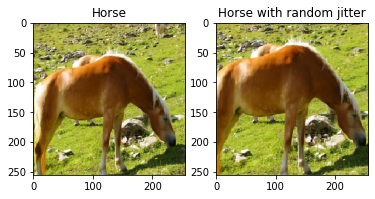

In [114]:
plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with random jitter')
plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)

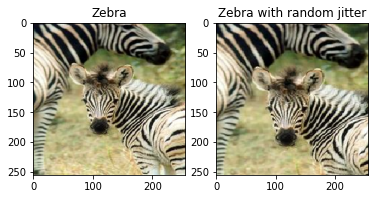

In [115]:
plt.subplot(121)
plt.title('Zebra')
plt.imshow(sample_zebra[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Zebra with random jitter')
plt.imshow(random_jitter(sample_zebra[0]) * 0.5 + 0.5)

In [116]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

# loss_network = tf.keras.applications.VGG16(
#       include_top=True,
#       weights="imagenet",
#       input_tensor=None,
#       input_shape=None,
#       pooling=None,
#       classes=1000,
#       classifier_activation="softmax",
# )

loss_network = VGG16(weights='imagenet')


In [117]:
import time
import keras
import torch
import torch.nn as nn
import torchvision

#loss_network = VGG16(weights='imagenet')


loss_input = loss_network.input
loss_layers = loss_network.layers
# layer_outputs = (layer.output for layer in loss_layers)
feat = tf.keras.models.Model(inputs=loss_input, outputs=[layer.output for layer in loss_layers])

def extract_features(Lossmodel, x, layers):
    features = list()

    x = x[0,0:224,0:224,:]
    x = tf.expand_dims(x,axis=0)
    # features = get_features()
    extracted_features = feat(x)
    for i in layers:
      features.append(extracted_features[i])

    return features


# def extract_features(Lossmodel, x, layers):
#     features = list()

#     x = x[0,0:224,0:224,:]
#     x = tf.expand_dims(x,axis=0)
    
#     for i in range(16): #add number of layers in original model
#       feat = tf.keras.models.Model(inputs = Lossmodel.inputs, outputs= Lossmodel.get_layer(index=i).output)
#       y = feat(x)
#       if i in layers:
#         #print(i)
#         features.append(y)
#     return features

def calc_Content_Loss(features, targets, weights=None):
    #print("inside content loss")

    if weights is None:
        weights = [1/len(features)] * len(features)
    
    content_loss = 0
    for f, t, w in zip(features, targets, weights):
        mse= tf.keras.losses.MeanSquaredError()
        content_loss +=   mse(f, t)*w      
        #content_loss = content_loss + (tf.math.reduce_mean((f - t)**2)*w)
    return content_loss

def gram(x):
    if len(x.shape) == 4:
      b ,c, h, w = x.shape
    elif len(x.shape) == 2:
      _, w = x.shape
      h = 1
      b = 1
      c = 1

    g = tf.matmul(tf.reshape(x,[b, c, h*w]), tf.transpose(tf.reshape(x,[b, c, h*w]), perm=[0,2,1]))
    return g/(c*h*w)

def calc_Gram_Loss(features, targets, weights=None):
    if weights is None:
        weights = [1/len(features)] * len(features)        
    gram_loss = 0
    for f, t, w in zip(features, targets, weights):        
        mse= tf.keras.losses.MeanSquaredError()
        gram_loss += mse(gram(f), gram(t))*w    
        #gram_loss += tf.norm((gram(f) - gram(t)))*w    
    return gram_loss

def calc_TV_Loss(x):
    tv_loss = tf.math.reduce_mean(tf.abs(x[:, :, :, :-1] - x[:, :, :, 1:]))
    tv_loss += tf.math.reduce_mean(tf.abs(x[:, :, :-1, :] - x[:, :, 1:, :]))
    return tv_loss

def perceptual_loss(Lossmodel, real_x, style_target, fake_y):
  
  target_content_features = extract_features(Lossmodel, real_x, [14])
  target_style_features = extract_features(Lossmodel, style_target, [8, 10, 15]) 

  output_content_features = extract_features(Lossmodel, fake_y, [14])
  output_style_features = extract_features(Lossmodel, fake_y, [8, 10, 15])

  content_loss = calc_Content_Loss(output_content_features, target_content_features)
  style_loss = calc_Gram_Loss(output_style_features, target_style_features)


  tv_loss = calc_TV_Loss(fake_y)

  total_loss = content_loss + style_loss*30 + tv_loss*1
  return total_loss

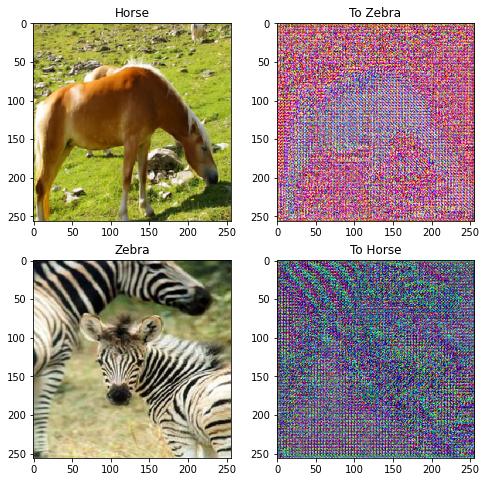

In [118]:
to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

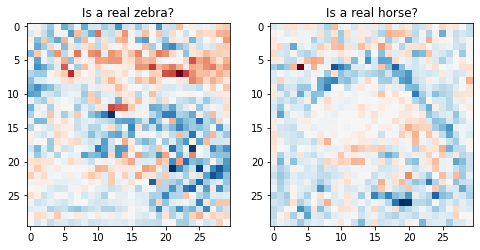

In [119]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_x(sample_horse)[0, ..., -1], cmap='RdBu_r')

plt.show()

In [120]:
LAMBDA = 10

In [121]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  return LAMBDA * loss1

In [122]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [123]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [124]:
EPOCHS = 100

In [125]:
def generate_images(model, test_input):
  prediction = model(test_input)  
  plt.figure(figsize=(12, 12))
  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']
  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [126]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X. 
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)
    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)
    w = 1
    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)
    # disc_real_x = discriminator_x(real_x, training=True)
    # disc_real_y = discriminator_y(real_y, training=True)
    # disc_fake_x = discriminator_x(fake_x, training=True)
    # disc_fake_y = discriminator_y(fake_y, training=True)
    # calculate the loss

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    style_target_zebra = sample_zebra
    style_target_horse = sample_horse
    # plt.figure(figsize=(12, 12))
    # plt.imshow(style_target_zebra[0])
    # plt.figure(figsize=(12, 12))
    # plt.imshow(style_target_horse[0])
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss =  total_cycle_loss + identity_loss(real_y, same_y) + w*perceptual_loss(loss_network, real_x, style_target_zebra, fake_y)
    total_gen_f_loss =  total_cycle_loss + identity_loss(real_x, same_x) + w*perceptual_loss(loss_network, real_y, style_target_horse, fake_x)

  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

In [128]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_horse)


## Generate using test dataset

In [ ]:
# Run the trained model on the test dataset
for inp in test_horses.take(5):
  generate_images(generator_g, inp)

## Next steps

This tutorial has shown how to implement CycleGAN starting from the generator and discriminator implemented in the [Pix2Pix](https://www.tensorflow.org/tutorials/generative/pix2pix) tutorial. As a next step, you could try using a different dataset from [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/cycle_gan). 

You could also train for a larger number of epochs to improve the results, or you could implement the modified ResNet generator used in the [paper](https://arxiv.org/abs/1703.10593) instead of the U-Net generator used here.